https://towardsdatascience.com/introduction-to-mesa-agent-based-modeling-in-python-bcb0596e1c9a

https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html

https://notebook.community/projectmesa/mesa-examples/examples/ForestFire/.ipynb_checkpoints/Forest%20Fire%20Model-checkpoint

To install Mesa, simply:

$ pip install mesa https://mesa.readthedocs.io/en/latest/apis/space.html

In [318]:
import random

import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace
from mesa.time import RandomActivation


#from mesa.datacollection import DataCollector
#from mesa.batchrunner import BatchRunner

In [319]:
class Bee(Agent):
    '''
    A Bee Boid-style flocker agent.

    The agent follows three behaviors to flock:
        - Cohesion: steering towards neighboring  queen agents.
        - Separation: avoiding getting too close to any other worker agent.
        - Alignment: try to fly in the same direction as the neighbors.

    Bees have a vision that defines the radius in which they look for their
    neighbors to flock with. Their speed (a scalar) and heading (a unit vector)
    define their movement. Separation is their desired minimum distance from
    any other Boid.
    '''
    
    def __init__(self, unique_id, model, pos, pollen=0, food=5, health=5, speed=5, heading=None,
                 vision=5, separation=1, atype=0):
        '''
        Create a new Bee flocker agent.

        Args:
            unique_id: Unique agent identifyer.
            pos: Starting position
            speed: Distance to move per step.
            heading: numpy vector for the Boid's direction of movement.
            vision: Radius to look around for nearby Queens/Plants.
            separation: Minimum distance to maintain from other Boids.
        '''
        super().__init__(unique_id, model)
        self.pos = pos
        self.food = food
        self.health = health
        self.pollen = pollen
        self.speed = speed
        self.atype=atype
        self.honey=0
        self.model=model
        if heading is not None:
            self.heading = heading
        else:
            self.heading = np.random.random(2)
            self.heading /= np.linalg.norm(self.heading)
        self.vision = vision
        self.separation = separation

    def cohere(self, neighbors):
        '''
        Return the vector toward the center of mass of the local neighbors.
        '''
        center = np.array([0.0, 0.0])
        count=0
        for neighbor in neighbors:
            if neighbor.atype == 0:
                center += np.array(neighbor.pos)
                count = count +1
        return center / count
    
    def cohereplant(self, neighbors):
        '''
        Return the vector toward the center of mass of the local neighbors.
        '''

        center = np.array([0.0, 0.0])
        count=0
        for neighbor in neighbors:
            if neighbor.atype == 1:
                center += np.array(neighbor.pos)
                count = count +1
        return center / count

    def coherequeen(self, neighbors):
        '''
        Return the vector toward the center of mass of the local neighbors.
        '''

        center = np.array([0.0, 0.0])
        count=0
        for neighbor in neighbors:
            if neighbor.atype == 2:
                center += np.array(neighbor.pos)
                count = count +1
        return center / count
    
    def separate(self, neighbors):
        '''
        Return a vector away from any neighbors closer than separation dist.
        '''
        my_pos = np.array(self.pos)
        sep_vector = np.array([0, 0])
        for neighbor in neighbors:
            if neighbor.atype == 0:
                their_pos = np.array(neighbor.pos)
                dist = np.linalg.norm(my_pos - their_pos)
                if dist < self.separation:
                    sep_vector -= np.int64(their_pos - my_pos)
        return sep_vector


    def step(self):
        '''
        Get the Boid's neighbors, compute the new vector, and move accordingly.
        '''

        neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
        
        
        if len(neighbors) > 0:
            cohere_vector = self.cohere(neighbors)
            if self.honey < 2:
                cohere_vector=self.coherequeen(neighbors)
            if self.pollen < 1:
                cohere_vector=self.cohereplant(neighbors)
            separate_vector = self.separate(neighbors)
            self.heading += (cohere_vector +
                             separate_vector )
            self.heading /= np.linalg.norm(self.heading)
        new_pos = np.array(self.pos) + self.heading * self.speed
        new_x, new_y = new_pos
        if math.isnan(new_x) or math.isnan(new_y):
            print("nan pos detected ")
        else:
            if new_x>model.space.x_max:
                new_x=model.space.x_min
            if new_x<model.space.x_min:
                new_x=model.space.x_max
            if new_y>model.space.y_max:
                new_y=model.space.y_min
            if new_y<model.space.y_min:
                new_y=model.space.y_max
            self.model.space.move_agent(self, (new_x, new_y))

In [320]:
class Plant(Agent):
    '''
    A Plant agent.

    Plant produes pollen bees take pollen from plant

    Separation is their desired minimum distance from
    any other Boid.
    '''
    
    def __init__(self, unique_id, model, pos, pollen =5, vision = 2, separation=1, atype=1):
        '''
        Create a new Plant agent.

        Args:
            unique_id: Unique agent identifyer.
            pos: Starting position
            speed: Distance to move per step.
            separation: Minimum distance to maintain from other Boids to give pollen.
        '''
        super().__init__(unique_id, model)
        self.pos = pos
        self.separation = separation
        self.pollen = 5
        self.atype = atype
        self.vision = vision
        self.time = 0


    def step(self):
        '''
        Get the Boid's neighbors, compute the new vector, and move accordingly.
        '''

        neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
        time=self.model.time
        my_pos = np.array(self.pos)
        for neighbor in neighbors:
            if neighbor.atype == 0:
                their_pos = np.array(neighbor.pos)
                dist = np.linalg.norm(my_pos - their_pos)
                #self.separation=8
                #print (" before transfer", dist, self.separation)
                if dist < self.separation:
                    #print("pollen transfer", self.pollen, neighbor.pollen)
                    if self.pollen > 0:
                        neighbor.pollen = neighbor.pollen + 10
                        self.pollen = self.pollen - 10
                        if self.pollen > 0 and neighbor.pollen>0:
                            neighbor.speed=0
                        else:
                            neighbor.speed=1
                        #print ('Pollen transfered', self.pollen, neighbor.pollen)
        
        if self.model.time % 30 == 0:
            #print("hooray more pollen")
            self.pollen=self.pollen+random.random()/20

In [321]:
class Queen(Agent):
    '''
    A Queen agent.

    Uses pollen to make food
    get pollen from bee
    queen make food
    queen give food to bee

    Separation is their desired minimum distance from
    any other Boid.
    '''
    
    def __init__(self, unique_id, model, pos, pollen=5, honey=5, vision=5, separation=1, atype=2):
        '''
        Create a new Queen agent.

        Args:
            unique_id: Unique agent identifyer.
            pos: Starting position
            speed: Distance to move per step.
            heading: numpy vector for the Boid's direction of movement.
            vision: Radius to look around for nearby Queens/Plants.
            separation: Minimum distance to maintain from other Boids.
        '''
        super().__init__(unique_id, model)
        self.pos = pos
        self.separation = separation
        self.pollen = pollen
        self.honey = honey
        self.atype = atype
        self.vision = vision

    def step(self):
        '''
        Get the Boid's neighbors, compute the new vector, and move accordingly.
        '''

        neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
        nworkers=0
        health=0
        my_pos = np.array(self.pos)
        #self.separation = 10
        for neighbor in neighbors:
            if neighbor.atype == 0:
                their_pos = np.array(neighbor.pos)
                dist = np.linalg.norm(my_pos - their_pos)
                if dist < self.separation:
                    nworkers=nworkers+1
                    health=health+neighbor.health
                    if neighbor.pollen > 0:
                        neighbor.pollen = neighbor.pollen - 1
                        self.pollen = self.pollen + 1
                if dist < self.separation:
                    print("Honey before",self.honey, neighbor.honey)
                    if self.honey > 0:
                        neighbor.honey = neighbor.honey + 1
                        self.honey = self.honey - 1
                        print("honey given", self.honey, neighbor.honey, self.unique_id)
                        if neighbor.pollen>0:
                            neighbor.speed = 0
                        else: 
                            neighbor.speed = 1
    
        #calculate number of workers near and use to make honey
        if nworkers>0:
            if self.pollen>0:
                self.honey=self.honey+self.pollen*(health/nworkers)
                self.pollen=self.pollen-nworkers
                



In [322]:
class HiveModel(Model):
    '''
    Hive model class. Handles agent creation, placement and scheduling.
    '''

    def __init__(self, NP, NB, NQ, width, height, speed, vision, pseparation, bseparation, qseparation):
        '''
        Create a new Flockers model.

        Args:
            N: Number of Boids
            width, height: Size of the space.
            speed: How fast should the Boids move.
            vision: How far around should each Boid look for its neighbors
            separtion: What's the minimum distance each Boid will attempt to
                       keep from any other
        '''
        
        #ContinuousSpace(x_max: float, y_max: float, torus: bool, x_min: float = 0, y_min: float = 0)
        self.NP = NP
        self.NB = NB
        self.NQ = NQ
        
        self.vision = vision
        self.speed = speed
        self.qseparation = qseparation
        self.pseparation = pseparation
        self.bseparation = bseparation
        self.schedule = RandomActivation(self)
        self.space = ContinuousSpace(width, height, True, 10, 10)
        self.make_agents()
        self.running = True
        self.time =0

    def make_agents(self):
        '''
        Create N agents, with random positions and starting headings.
        '''
        for i in range(self.NB):
            x = random.random() * self.space.x_max
            y = random.random() * self.space.y_max
            pos = (x, y)
            heading = np.random.random(2) * 2 - np.array((1, 1))
            heading /= np.linalg.norm(heading)
            bee = Bee(i, self, pos, 0, 0,5,self.speed, heading, self.vision,
                        self.bseparation)
            self.space.place_agent(bee, pos)
            self.schedule.add(bee)
        for i in range(self.NP):
            x = random.random() * self.space.x_max
            y = random.random() * self.space.y_max
            pos = (x, y)
            plant = Plant(i+self.NB, self, pos, 5, self.vision,
                        self.pseparation)
            self.space.place_agent(plant, pos)
            self.schedule.add(plant)
        for i in range(self.NQ):
            x = random.random() * self.space.x_max
            y = random.random() * self.space.y_max
            pos = (x, y)
            queen = Queen(i+self.NB+self.NP, self, pos, 5, 5, self.vision,
                        self.qseparation)
            self.space.place_agent(queen, pos)
            self.schedule.add(queen)            


    def step(self):
        self.time = self.time+1
        self.schedule.step()

In [323]:
def draw_boids(model):
    x_vals = []
    y_vals = []
    t_vals=[]
    cols = []
    
    for boid in model.schedule.agents:
        x, y = boid.pos
        if boid.atype == 0:
            atype=1
            cols.append(1+atype)
        if boid.atype == 1:
            cols.append(2+boid.pollen)
            atype=10
        if boid.atype == 2:
            cols.append(2+boid.honey)
            atype=50
        #cols.append(1)
        x_vals.append(x)
        y_vals.append(y)
        t_vals.append(100*atype)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.scatter(x_vals, y_vals, s=t_vals, c=cols, alpha=0.5)

In [324]:
model = HiveModel(10, 50, 3, 100, 100, speed=1, vision=20, pseparation=4, bseparation=1, qseparation=10)

In [335]:
for i in range(15):
    model.step()
    print(model.time)
    #draw_boids(model)

/Users/mikegriffiths/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
/Users/mikegriffiths/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/mikegriffiths/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
Honey before 0.0 38
Honey before 0.0 14
Honey before 0.0 22
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
76
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
n

nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
87
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
Honey before 0.0 38
Honey before 0.0 14
Honey before 0.0 22
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
nan pos detected 
Honey before 43.0 2

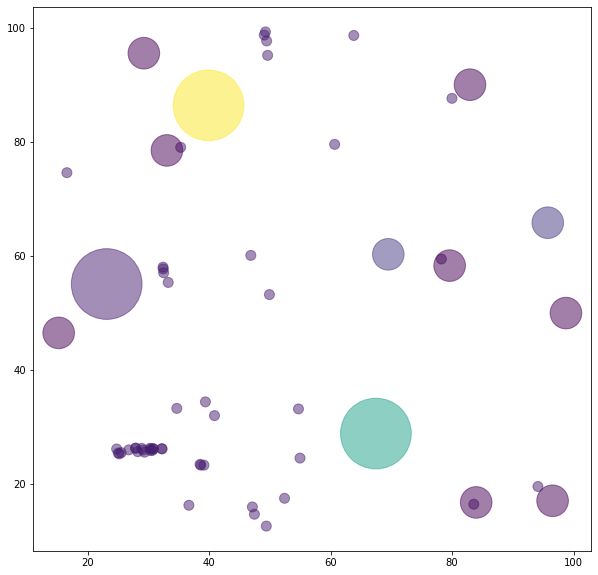

In [336]:
draw_boids(model)

In [252]:

for boid in model.schedule.agents:
            if boid.atype == 0:
                print(boid.honey, boid.pollen, boid.speed)       

0 10 1
0 0 1
0 20 1
0 10 1
0 10 1
0 10 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
10 0 1
0 0 1
0 0 1
0 0 1
4 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 10 1
10 0 1
0 0 1
14 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
8 0 1
6 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 10 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 10 1


In [253]:
for boid in model.schedule.agents:
            if boid.atype == 1:
                print(boid.pollen)

-5
5
-5
-5
-5
-5
-5
-5
-5
-5


In [254]:
for boid in model.schedule.agents:
            if boid.atype == 2:
                print(boid.honey,boid.pollen)

30.0 -1
66.0 0
52.0 -1


In [316]:
for boid in model.schedule.agents:
            if boid.atype == 0:
                x,y=boid.pos
                print(x, y, boid.speed)    

36.134506408062926 75.15659967483285 1
nan nan 1
33.0307552568988 53.74671675609955 1
nan nan 1
28.550968332309452 29.524513370538457 1
nan nan 1
12.478547327143689 82.53415275367452 1
37.795820645633995 60.98841775840489 1
10 86.07359767882367 1
73.07106508268923 13.93022912703377 1
nan nan 1
13.331480860075928 41.39236396690008 1
30.71920126547172 47.82668886337766 1
nan nan 1
71.87921760608229 90.57417906972012 1
16.570153743655236 25.166437291178127 1
10 85.8784623893072 1
98.10713101465767 71.93418938037482 1
77.32404957475408 48.20233571783197 1
69.16352863428185 98.15332876849314 1
57.36569199799679 45.44738760733009 1
71.66766773896566 96.63530266745896 1
nan nan 1
nan nan 1
95.59390724739211 66.10720164340688 1
nan nan 1
32.086879716958045 17.460160573485524 1
28.38472801074012 81.08505902046144 1
nan nan 1
nan nan 1
nan nan 1
91.2604222618181 51.95229256865244 1
nan nan 1
nan nan 1
85.80492010994654 86.1818096667049 1
10 81.18330429164332 1
nan nan 1
nan nan 1
68.632496099977